# Transformation of Halo Energy Budgets during The Formation of Samyog (Major MW-M31 Merger Remnant)

### Question: 
1. Is the dark matter halo of the Major MW-M31 Merger Remnant, Samyog, dominantly dispersion supported or dominantly rotation supported? We also wish to compare it to its predecessor in terms of this property.
2. Does the dark matter halo of M33 gains energy or looses energy and how that changes its internal structure in terms of it being more dispersion depended?

### Plots: 
In this assignment, we will be calculating internal energies (kinetic, potential, and total) of the three galaxy haloes before the merger and two remnant galaxy haloes after the merger. We will plot four plots for this assignment which are similar to the this figure (Drakos+2019):

<img src="two_galaxy_merger.jpg" />

On the x-axis, we will have time in Gyrs, and on the y-axis, we will have two subplots on top of each others with the top one showing internal energy budgets, and the bottom one showing the virial ratio. For the first and second plot, we will plot MW and M31, respectively, before t = 5.86 Gyrs (van der Marel+2012). For the third plot, we will plot Samyog after t = 5.86 Gyrs. The final plot will look at M33 for the entirety of the timeline. 

As stated before, we are only interested in the dark matter halo here, so we are only using the dark matter particles. We iterate over the all 800 snapshots with an interval of 40 snapshots. Looking at the internal energy budgets evolutions as well as the evolution of the virial ratio as the merger occurs would help us understand where the energy goes as well as how the internal structures of the galaxies change as the merger occurs. This is exactly what we want to answer. 

### Outline:

1. Write a function to store halo data from given data file.
2. Write a function to store halo data into center of mass reference frame.
2. Write a function to calculate internal potential energy of any halo.
3. Write a function to calculate internal kinetic energy of any halo.
4. Write a function to calculate total internal energy of any halo and return KE_{int}, PE_{int}, TE_{int}.
5. Write a function to loop over data files to store a continuous energy evolution of different haloes for a given time period.
7. Write a function to create plots of various internal energy budgets before and after the merger.

In [90]:
# importing modules:
import numpy as np
import astropy.units as u
import astropy.constants as const

# importing plotting modules
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

# my modules
from ReadFile import Read
from CenterOfMass2 import CenterOfMass

#### 1. Write a function to store halo data from given data file:

We will utilize ReadFile.py that we have written in the homework to read in the data files.

In [29]:
def reading_dm_data(filename):
    """
    This function reads in dark matter data from a given file and stores it as a numpy array.
    
    Parameters
    ----------
    filename: string
        name of the data file
        
    Return
    ------
    t: astropy.Quantity
        time of the snapshot in Gyrs
    
    dm_data: numpy.array
        dark matter data 
    """
    
    # Reading in the data from the data file:
    t, n, data = Read(filename)
    
    # Converting time of the snapshot to Gyrs
    t = t.to(u.Gyr)
    
    # Creating an array to store indexes of DM particles:
    index = np.where(data['type'] == 1)

    # Storing the mass, positions, velocities of the DM particles in the Center Of Mass reference frame:
    m = data['m'][index]*1e+10       # Storing mass in Msun
    x = data['x'][index]             # Storing x- coordinate in kpc
    y = data['y'][index]             # Storing y-coordinate in kpc
    z = data['z'][index]             # Storing z-coordinate in kpc
    vx = data['vx'][index]           # Storing x-velocity in km/s
    vy = data['vy'][index]           # Storing y-velocity in km/s 
    vz = data['vz'][index]           # Storing z-velocity in km/s
    
    # Stacking columns to create a single numpy array: 
    dm_data = np.stack((m, x, y, z, vx, vy, vz), axis=1)

    return t, dm_data

In [30]:
filename = "C:/Users/ual-laptop/mystuff/ASTR_400B/Data/M31_000.txt"
t, data = reading_dm_data(filename)

##### 2. Write a function to store halo data into center of mass reference frame

We will utilize CenterOfMass class in CenterOfMass2.py that we have written in the homework to find the Center Of Mass of the haloes for each galaxies. We will covert all the position and velocity coordinates of all the dark matter particle into the Center Of Mass reference frame. Then, we will store the data for dark matter particles as a numpy array.

In [43]:
def data_COM_frame(data):
    """
    This function calculates the COM of the dm halo. Then, it coverts the data to COM reference frame.
    
    Parameters
    ----------
    data: np.array
        dm particle data
    
    Returns
    -------
    data: np.array
        dm particle data in COM reference frame
    """
    
    # Setting tolerance and VolDec for calculating COM_P in CenterOfMass
    # We use these values because for dm particles we consider the whole halo to find COM
    delta = 0.1
    volDec = 1
        
    # Initialize an instance of CenterOfMass class, using dark matter particles
    COM = CenterOfMass(data)
      
    # Storing the COM pos. and vel.
    COM_p = COM.COM_P(delta, volDec)
    COM_v = COM.COM_V(COM_p[0], COM_p[1], COM_p[2])
    COM_p, COM_v = COM_p.value, COM_v.value
    
    # storing data into COM reference frame
    data[:,1] = data[:,1] - COM_p[0]          
    data[:,2] = data[:,2] - COM_p[1]            
    data[:,3] = data[:,3] - COM_p[2]
    data[:,4] = data[:,4] - COM_v[0]
    data[:,5] = data[:,5] - COM_v[1]
    data[:,6] = data[:,6] - COM_v[2]
    
    return data

#### 2. Write a function to calculate internal potential energy of any halo:

To find the internal potential energy of any given halo, we use the equation,

\begin{align}
    P_{int,g} &= - \Sigma_{i \neq j}^{N_g} \frac{G m_i m_j}{r_{ij}}.
    \label{eq:potential_energy}
\end{align}

In [32]:
def int_potential_energy(data):
    """
    This function calculates the internal potential energy of a halo.
    
    Parameters
    ----------
    data: numpy.array
        dark matter data
        
    Returns
    -------
    PE: astropy.Quantity
        total internal potential energy of the halo in Jules
    """
    
    # Defining G in m^3/s^2/kg:
    G = const.G
    
    # extracting data:
    m = data[:,0]*u.Msun            # extracting mass 
    x = data[:,1]*u.kpc             # extracting x-coordinate
    y = data[:,2]*u.kpc             # extracting y-coordinate
    z = data[:,3]*u.kpc             # extracting z-coordinate
    
    # Converting to SI units
    m = m.to(u.kg)
    x,y,z = x.to(u.m), y.to(u.m), z.to(u.m)
    
    # Looping over each particle to calculate PE associated with it:
    PE = 0
    tot_size = m.size
    for i in range(tot_size):
        # Calculating sum_{j;j!=i} G*mi*mj/rij   (i is fixed here):
        
        # Extracting mi:
        m_i = m[0]
        
        # Deleting mi from m array, these will be our 'mj's:
        m = np.delete(m,0)
        
        # Finding 'G*mi*mj's: 
        G_mi_mj = G*m_i*m
        
        # extracting pos. of ith particle:
        x_i, y_i, z_i = x[0], y[0], z[0]
        
        # deleting pos. of ith particles from the pos. coordinates arrays of all particles, 
        # these will be our pos. of all jth particles:
        x, y, z = np.delete(x, 0), np.delete(y, 0), np.delete(z, 0)
        
        # finding seperation, rij:
        x_sep = x - x_i
        y_sep = y - y_i
        z_sep = z - z_i
        r_sep = np.sqrt(x_sep**2 + y_sep**2 + z_sep**2)
        
        # Avoiding where r_sep = 0:  (I don't know why? They should not be.)
        ind_rem = np.where(r_sep==0)
        sum_arr = - np.delete(G_mi_mj, ind_rem, axis=0) / np.delete(r_sep, ind_rem, axis=0)
        
        # Summing over the potential values for fixed ith particle using np.sum() and 
        # in return the loop helps to sum over the different values of i through iteration: 
        PE += np.sum(sum_arr)
    
    return PE

In [33]:
calc_PE = int_potential_energy(data)   # For M31 at t=0
calc_PE

<Quantity -8.74993048e+52 kg m2 / s2>

We fact-check this value using the Hernquist potential energy (Narasimhan+1997): 

\begin{align}
    U = - \frac{GM^2}{6a},
    \label{eq:hernquist_potential_energy}
\end{align} 

where a is the scale radius of Hernquist profile taken here as $a=60 kpc$ for M31 as our calculations in Homework 5.

In [34]:
def Hernquist_potential_energy(data, a):
    """
    This function calculates the Hernquist potential energy of a halo.
    
    Parameters
    ----------
    data: numpy.array
        dark matter data
    a: float
        Scale radius for the Hernquist profile in kpc.
        
    Returns
    -------
    U: astropy.Quantity
        Hernquist potential energy of the halo in Jules
    """
    
    # Defining G in m^3/s^2/kg:
    G = const.G
    
    # extracting data:
    m = data[:,0]*u.Msun            # extracting mass
    
    # Converting to SI units
    m = m.to(u.kg)
    a = a*u.kpc
    a = a.to(u.m)
    
    # Calculating the total mass:
    M = np.sum(m)
    
    # Calculating the Hernquist potential energy:
    U = - G * M**2 / 6 / a
    
    return U

In [35]:
theo_PE = Hernquist_potential_energy(data, 60)
theo_PE

<Quantity -8.76527017e+52 kg m2 / s2>

In [36]:
print("Percentage Error = " + str(np.abs((calc_PE-theo_PE)*100/theo_PE)) + " %")

Percentage Error = 0.17500534779366173 %


#### 3. Write a function to calculate internal kinetic energy of any halo:
To find the internal kinetic energy of any given halo, we use the equation,

\begin{align}
    K_{int,g} &= \frac{1}{2}\Sigma_{i=1}^{N_g} m_i v_i^2.
    \label{eq:kinetic_energy}
\end{align}

In [37]:
def int_kinetic_energy(data):
    """
    This function calculates the internal kinetic energy of a halo.
    
    Parameters
    ----------
    dm_data: numpy.array
        dark matter data
        
    Returns
    -------
    KE: astropy.Quantity
        total internal kinetic energy of the halo in Jules
    """
    
    # extracting data:
    m = data[:,0]*u.Msun            # extracting mass 
    vx = data[:,4]*u.km/u.s          # extracting x-velocity
    vy = data[:,5]*u.km/u.s          # extracting y-velocity
    vz = data[:,6]*u.km/u.s          # extracting z-velocity

    # Converting to SI units
    m = m.to(u.kg)
    vx, vy, vz = vx.to(u.m/u.s), vy.to(u.m/u.s), vz.to(u.m/u.s)
    # Finding the speed of particles:
    v_squared = vx**2 + vy**2 + vz**2
    
    # Calculating the total internal kinetic energy by summing over the kinetic energy of each particle using a loop:
    KE = np.sum(0.5*m*v_squared)
    
    return KE

In [38]:
int_kinetic_energy(data) # For M31 at t=0

<Quantity 8.21812929e+52 kg m2 / s2>

#### 4. Write a function to calculate total internal energy of any halo and return KE_{int}, PE_{int}, TE_{int}:

To find the internal kinetic energy of any given halo, we use the equation,

\begin{align}
    E_{int,g} = K_{int,g} + P_{int,g},
    \label{eq:total_internal_energy}
\end{align}

In [39]:
def int_energy(data):
    """
    This function calculates the total internal energy,  of a halo.
    
    Parameters
    ----------
    dm_data: numpy.array
        dark matter data
        
    Returns
    -------
    energies: numpy.array of astropy.Quantity
            numpy array storing astropy quantities of internal PE, KE, and TE, respectively, of given halo in Jules.
    """
    
    # Finding internal kinetic and potential energies:
    KE = int_kinetic_energy(data)
    PE = int_potential_energy(data)
    
    # Calculating total internal energy:
    TE = KE + PE
    
    energies = np.array([KE.value, PE.value, TE.value])*TE.unit
    
    return energies

In [40]:
int_energy(data) # For M31 at t=0

<Quantity [ 8.21812929e+52, -8.74993048e+52, -5.31801196e+51] kg m2 / s2>

#### 5. Write a function to loop over data files to store a continuous energy evolution of different haloes for a given time period:
We will write a function that loops over the different snapshots of each galaxy and calculates the energy budgets. We will start with calculating energy budgets for all three galaxy (MW, M31, and M33) haloes. After t=5.86 Gyr, we will switch to calculating the energy budgets for M33 and Samyog haloes. 

Here, we are assuming that for t>5.86 Gyr the MW and M31 to be merged (van der Marel+2012). So, this is when we will start tracking the energy budget of the Samyog's, the MW+M31 major merger remnant's, halo rather than seperate MW & M31. Thus, we combine the data for MW and M31 for the calculations after t=5.86Gyr. 

In [41]:
def energy_budget_evolution(start, end, n):
    """
    This function calculates the energy budget of haloes in our system over time and stores it in two seperate files 
    for times before and after the merger.
    
    Parameters
    ----------
    start: int
        The number of the first snapshot to be read in.
    end: int
        The number of the last snapshot to be read in.
    n: int
        The intervals over which the function will calculate energies.
    """
    
    # generate the snapshot id sequence: 
    snap_ids = np.arange(start, end, n)
    
    # Checking if the input is eligible:
    if snap_ids.size == 0:
        print("Check your start, end, or n values.")
        pass
    
    # Initializing two arrays to store energy budget values before and after the merger:
    energies_before = np.zeros((1,10))
    energies_after = np.zeros((1,7))
    
    # Looping over each snapshot:
    for i, snap_id in enumerate(snap_ids):  # loop over snapshots
        
        # Composing the data filenames:
        # Adding a string of the filenumber to the value “000”:
        ilbl = '000' + str(snap_id)
        # Removing all but the last 3 digits:
        ilbl = ilbl[-3:]
        # Filenames:
        filename_MW= "C:/Users/ual-laptop/mystuff/ASTR_400B/Data/MW_" + ilbl + '.txt'
        filename_M31= "C:/Users/ual-laptop/mystuff/ASTR_400B/Data/M31_" + ilbl + '.txt'
        filename_M33= "C:/Users/ual-laptop/mystuff/ASTR_400B/Data/M33_" + ilbl + '.txt'
        
        # Reading in the files:
        t, data_MW = reading_dm_data(filename_MW)
        t, data_M31 = reading_dm_data(filename_M31)
        t, data_M33 = reading_dm_data(filename_M33)
        
        # Storing energies before the merger:
        if t.value <= 5.86:
            
            #Converting to COM reference frame:
            data_MW = data_COM_frame(data_MW)
            data_M31 = data_COM_frame(data_M31)
            data_M33 = data_COM_frame(data_M33)
            
            # Extracting internal energies of each halo:
            MW_energies = int_energy(data_MW)
            M31_energies = int_energy(data_M31)
            M33_energies = int_energy(data_M33)
            
            # Appending the internal enrgies of all galaxies at a given time:
            row = np.append(np.array([t.value]), np.array([MW_energies.value, M31_energies.value, M33_energies.value]))
            energies_before = np.append(energies_before, np.array([row]), axis=0)
        
        else:
            
            # Combining MW+M31 data for energy calculations of Samyog:
            data_Samyog = np.append(data_MW, data_M31, axis=0)
            
            #Converting to COM reference frame:
            data_Samyog = data_COM_frame(data_Samyog)
            data_M33 = data_COM_frame(data_M33)
            
            # Extracting internal energies of each halo:
            Samyog_energies = int_energy(data_Samyog)
            M33_energies = int_energy(data_M33)
            
            # Appending the internal enrgies of all galaxies at a given time:
            row = np.append(np.array([t.value]), np.array([Samyog_energies.value, M33_energies.value]))
            energies_after = np.append(energies_after, np.array([row]), axis=0)
    
    # Getting rid of the first row containing zeros used for initializing the arrays:
    energies_before = energies_before[1:,:]
    energies_after = energies_after[1:,:]
    
    # Writing the data to two files:
    # we do this because we don't want to have to repeat this process 
    # this code should only have to be called once.
    np.savetxt("int_energies_premerger.txt", energies_before)
    
    np.savetxt("int_energies_postmerger.txt", energies_after)
    
    return energies_before, energies_after

In [42]:
data_before, data_after = energy_budget_evolution(0, 801, 40)

#### 6. Write functions to create plots of various internal energy budgets before and after the merger:
Let's plot something fun to look at!

In [44]:
def reading_energydata(galaxy):
    """
    This function gives reads in energy data that we calculated and prepares it for the four plots.
    
    Parameters
    ----------
    galaxy: str
        name of galaxy
        choose from "MW", "M31", "M33", or "Samyog"
    """
    # Reading in the derived internal energy data:
    premerger_data = np.genfromtxt("int_energies_premerger.txt")
    postmerger_data = np.genfromtxt("int_energies_postmerger.txt")
    
    if galaxy == "MW":
        t = premerger_data[:,0]
        KE, PE, TE = premerger_data[:,1], premerger_data[:,2], premerger_data[:,3]
    elif galaxy == "M31":
        t = premerger_data[:,0]
        KE, PE, TE = premerger_data[:,4], premerger_data[:,5], premerger_data[:,6]
    elif galaxy == "Samyog":
        t = postmerger_data[:,0]
        KE, PE, TE = postmerger_data[:,1], postmerger_data[:,2], postmerger_data[:,3]
    else:
        t = premerger_data[:,0]
        KE, PE, TE = premerger_data[:,7], premerger_data[:,8], premerger_data[:,9]
        t = np.concatenate((t, postmerger_data[:,0]), axis=0)
        KE = np.concatenate((KE, postmerger_data[:,4]), axis=0)
        PE = np.concatenate((PE, postmerger_data[:,5]), axis=0)
        TE = np.concatenate((TE, postmerger_data[:,6]), axis=0)
    
    return t, KE, PE, TE

In [85]:
def plotting(galaxy):
    """
    This function plots the internal energy budgets of different haloes as well as its virial ratios.
    
    Parameters
    ----------
    galaxy: str
        name of galaxy
        choose from "MW", "M31", "M33", or "Samyog"
    """
    # Extracting energy data:
    t, KE, PE, TE = reading_energydata(galaxy)
    
    # Plotting adjecent subplots:
    fig, axs = plt.subplots(2, 1, figsize=(10,10), sharex=True)
    
    # Removing vertical space between axes:
    fig.subplots_adjust(hspace=0)

    # Plotting internal energies:
    axs[0].plot(t, KE/1e52, color="red", label="KE")
    axs[0].plot(t, PE/1e52, color="blue", label="PE")
    axs[0].plot(t, TE/1e52, color="black", label="TE")
    axs[0].set_ylabel(r"E [$10^{52}$ J]", fontsize=22)
    
    # Plotting virial ratio:
    axs[1].plot(t, -PE/2/KE, linestyle="--", color="brown", label="Virial Ratio")
    axs[1].hlines(1, t[0], t[-1], color="green")
    axs[1].set_ylabel(r"$-\frac{P}{2K}$", fontsize=22)
    axs[1].set_ylim(0.0,1.1)
    
    #axs[0].set_yticks(np.arange(-0.9, 1.0, 0.4))
    #axs[0].set_ylim(-1, 1)

    # Adding Title:
    fig.suptitle("Evolution of Internal Energy Budgets and Virial Ratio of " + galaxy + " Halo", fontsize=16)
    
    # Adding axis labels:
    fig.supxlabel('Time [Gyrs]', fontsize=22)
    
    #plt.yscale("log")

    # Adjusting tick label font size:
    #label_size = 22
    #mpl.rcParams['xtick.labelsize'] = label_size 
    #mpl.rcParams['ytick.labelsize'] = label_size
    
    # Adding a legend with some customizations:
    legend = fig.legend(loc=(0.13, 0.75),fontsize='x-large') 

    plt.savefig(galaxy+'_energies_virial_ratios.png')
    
    plt.show()

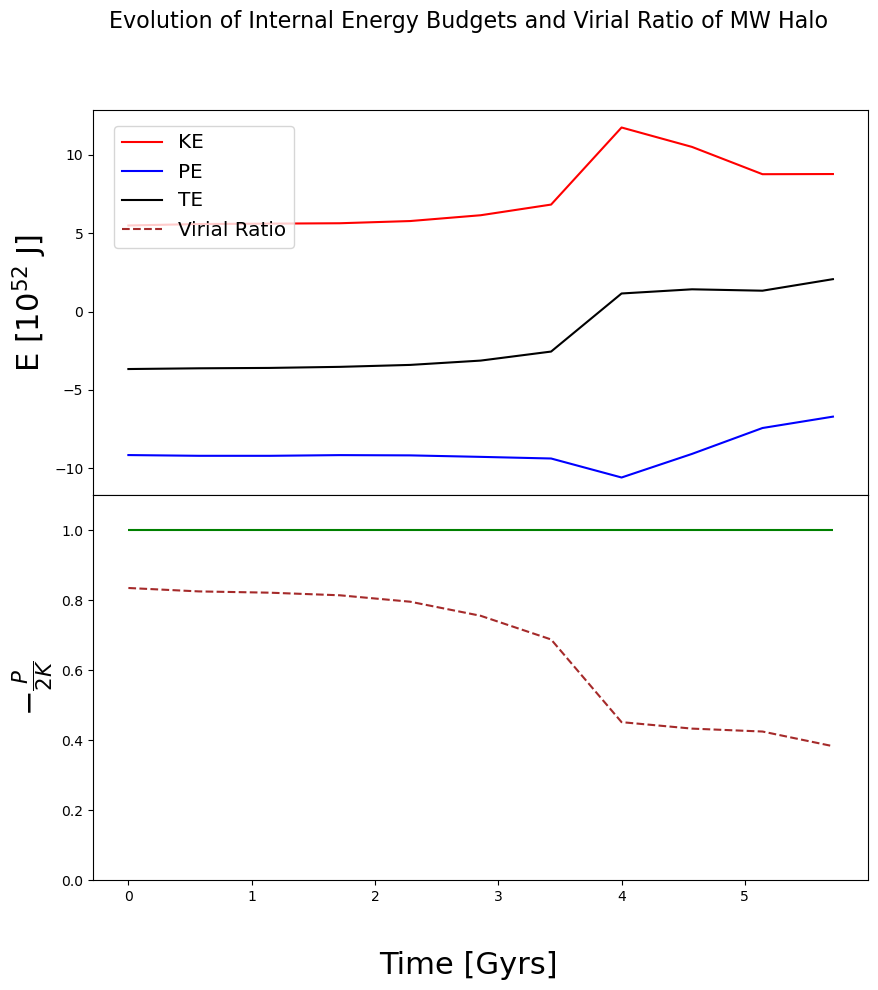

In [86]:
plotting("MW")

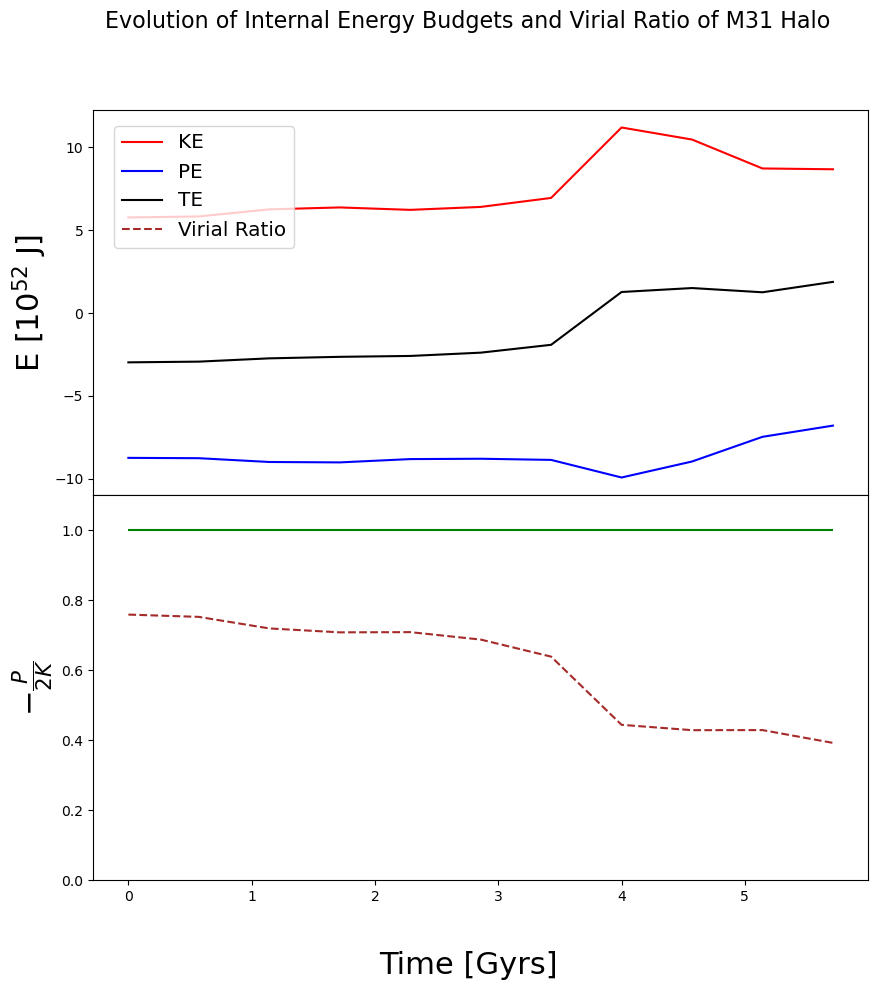

In [87]:
plotting("M31")

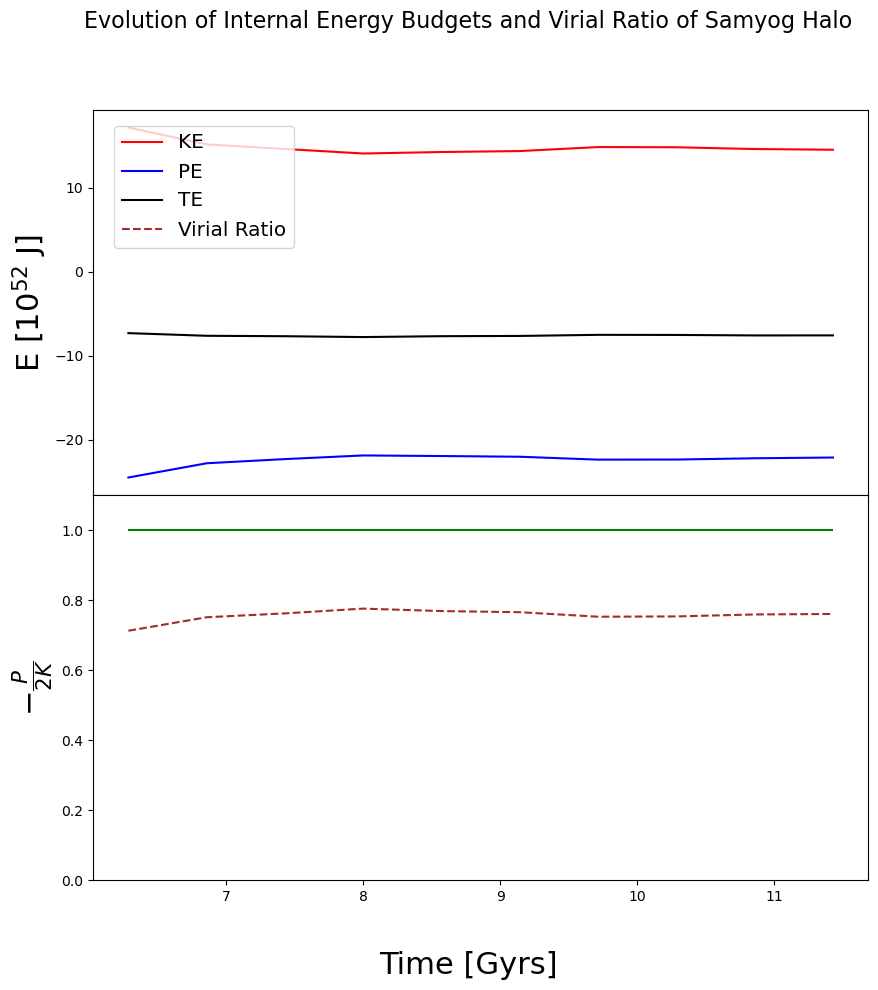

In [88]:
plotting("Samyog")

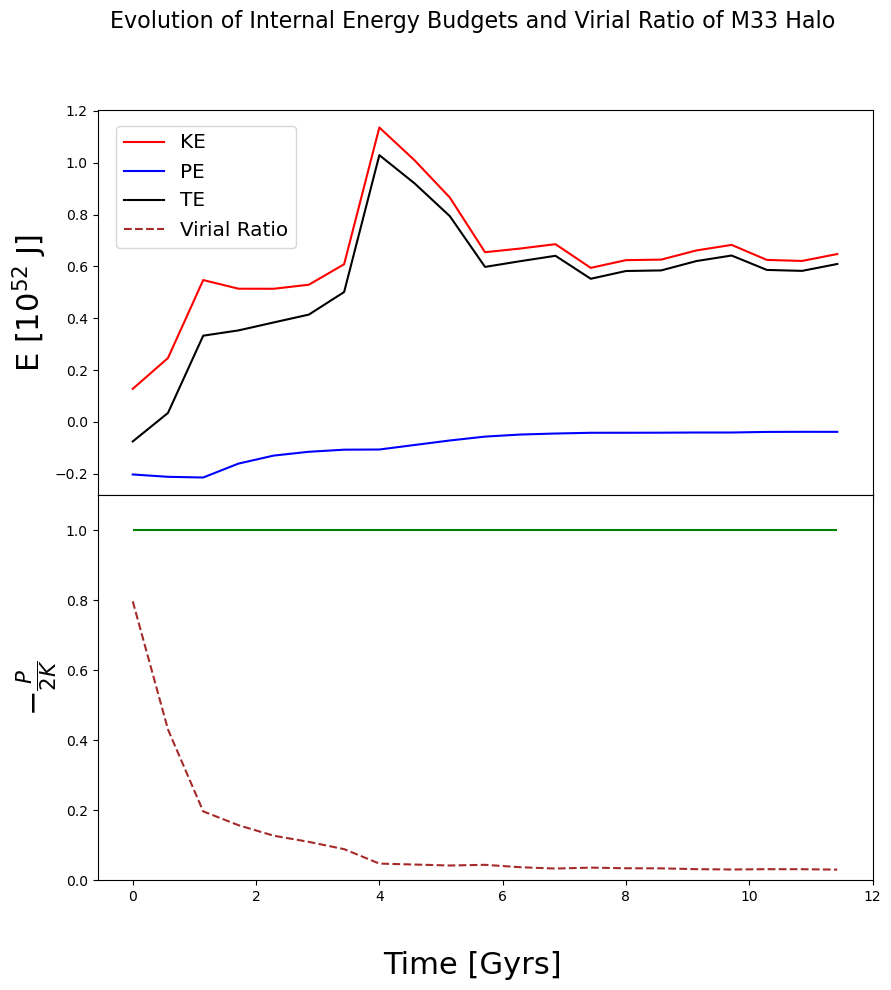

In [89]:
plotting("M33")

In [95]:
t_MW, KE_MW, PE_MW, TE_MW = reading_energydata("MW")
t_MW[0], KE_MW[0], PE_MW[0], TE_MW[0]

(0.0, 5.487200109145795e+52, -9.156011767342275e+52, -3.66881165819648e+52)

In [97]:
virial_MW = -PE_MW[0]/2/KE_MW[0]
virial_MW

0.8343063479753076

In [98]:
t_M31, KE_M31, PE_M31, TE_M31 = reading_energydata("M31")
t_M31[0], KE_M31[0], PE_M31[0], TE_M31[0]

(0.0, 5.769406937744851e+52, -8.749930482586237e+52, -2.9805235448413865e+52)

In [99]:
virial_M31 = -PE_M31[0]/2/KE_M31[0]
virial_M31

0.7583041530093919

In [102]:
t_Samyog, KE_Samyog, PE_Samyog, TE_Samyog = reading_energydata("Samyog")
t_Samyog[-1], KE_Samyog[-1], PE_Samyog[-1], TE_Samyog[-1]

(11.42857143,
 1.4532148985233405e+53,
 -2.2090466806616735e+53,
 -7.558317821383331e+52)

In [103]:
virial_Samyog = -PE_Samyog[-1]/2/KE_Samyog[-1]
virial_Samyog

0.7600550623677058

In [107]:
t_M33, KE_M33, PE_M33, TE_M33 = reading_energydata("M33")
t_M33[0], KE_M33[0], PE_M33[0], TE_M33[0]

(0.0, 1.2742850420597731e+51, -2.0293126971359586e+51, -7.550276550761855e+50)

In [108]:
virial_M33 = -PE_M33[0]/2/KE_M33[0]
virial_M33

0.7962554021099344

In [109]:
t_M33, KE_M33, PE_M33, TE_M33 = reading_energydata("M33")
t_M33[-1], KE_M33[-1], PE_M33[-1], TE_M33[-1]

(11.42857143,
 6.47833772237601e+51,
 -3.842286091052748e+50,
 6.094109113270735e+51)

In [110]:
virial_M33 = -PE_M33[-1]/2/KE_M33[-1]
virial_M33

0.029654876418232962